### Description: This script will explore how we could we could use Google's flood forecasting data operationally, using the reforecast for the 2020 flood event (between May and June)

#### Step 1: Import Libraries

In [15]:
import datetime
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import gcsfs

#### Step 2: Load Files

In [16]:
# Function for opening zarr datasets
def open_zarr(path):
  return xr.open_zarr(
      store=path,
      chunks=None,
      storage_options=dict(token='anon')
      )

In [17]:
# Set file paths
base_directory = 'gs://flood-forecasting/hydrologic_predictions/model_id_8583a5c2_v0/'
reforecast_path = os.path.join(base_directory, 'reforecast/streamflow.zarr/')
return_periods_path = os.path.join(base_directory, 'return_periods.zarr/')
hydrobasin_path = os.path.join(os.pardir, 'data', 'Kenya_hybas_L12.shp')

In [18]:
# Load files
reforecast_ds = open_zarr(reforecast_path)
return_periods_ds = open_zarr(return_periods_path)
hydrobasins = gpd.read_file(hydrobasin_path)
print(f'{reforecast_ds.sizes = }')
print(f'{return_periods_ds.sizes = }')

C:\Users\Mark.DESKTOP-UFHIN6T\AppData\Local\Temp\ipykernel_20684\3731592437.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  return xr.open_zarr(


reforecast_ds.sizes = Frozen({'gauge_id': 1031646, 'issue_time': 2738, 'lead_time': 8})
return_periods_ds.sizes = Frozen({'gauge_id': 1031646})


#### Step 3: Filter datasets by Kenyan hydrobasins

In [19]:
# Extract all the basin IDs in our HydroBasin dataset
kenya_basin_ids = hydrobasins['HYBAS_ID'].unique()
kenya_basin_ids = [f"hybas_{basin_id}" for basin_id in kenya_basin_ids]
# Get the gauge IDs from the reanalysis dataset.
reforecast_ids = reforecast_ds.gauge_id.values.astype(str)
# Find common basin IDs
common_ids = np.intersect1d(kenya_basin_ids, reforecast_ids)
# Filter the reanalysis dataset using only the common IDs
filtered_reforecast_ds = reforecast_ds.sel(gauge_id=common_ids)
# Filter the return period dataset using the same IDs
filtered_return_periods_ds = return_periods_ds.sel(gauge_id=common_ids)

#### Step 4: Function for calculating return period given streamflow

In [20]:
# Define function for running operation
def estimate_return_period(streamflow, gauge_id, rp_df):
    '''
    Function takes as input a streamflow value and interpolates the resultant return period
    from the RP dataframe for that specific hydrobasin
    '''
    # Filter row corresponding to the gauge_id
    row = rp_df[rp_df['gauge_id'] == gauge_id]
    if row.empty:
        return np.nan
    
    # Get all columns that start with "return_period_"
    rp_columns = [col for col in row.columns if col.startswith("return_period_")]
    
    # Create lists for the return period values and streamflow thresholds
    rp_values = []
    flow_thresholds = []
    for col in rp_columns:
        # extract numeric part of column name
        try:
            rp = float(col.split("_")[-1])
        except ValueError:
            continue
        rp_values.append(rp)
        flow_thresholds.append(row[col].values[0])
    
    # Convert to numpy arrays
    flow_thresholds = np.array(flow_thresholds)
    rp_values = np.array(rp_values)
    
    # Sort by flow thresholds
    sort_idx = np.argsort(flow_thresholds)
    flow_thresholds = flow_thresholds[sort_idx]
    rp_values = rp_values[sort_idx]
    
    # Check if streamflow is below the smallest threshold or above highest threshold
    if streamflow <= flow_thresholds[0]:
        return 0 # if it is below 2-year RP we will report 0
    if streamflow >= flow_thresholds[-1]:
        return rp_values[-1] # going to assume it's largest RP (200)
    
    # Linear interpolation for all other cases
    estimated_rp = np.interp(streamflow, flow_thresholds, rp_values)
    
    return estimated_rp

#### Step 5: Forecast at different lead times

In [21]:
# What date are we interested in?
selected_date = pd.to_datetime("2020-05-02")

In [22]:
# First need to extract relevant dates from original reforecast dataset - T - 7 days (to account for all lead times)
list_of_dfs = [] # will add to this list then concat

for L in range(8):  # L = 0..7
    # The issue_time that yields a forecast ending on 'selected_date' at lead L
    issue_t = selected_date - pd.Timedelta(days=L)
    
    # Slice the dataset for that specific issue_time and lead_time
    # (Make sure these coordinates exist in your data)
    da = filtered_reforecast_ds.sel(
        issue_time=issue_t,
    )
    
    # Convert to DataFrame
    df = da.to_dataframe().reset_index()
    
    list_of_dfs.append(df)

# Concat alll 8 slices into one dataframe
reforecast_lead_df = pd.concat(list_of_dfs, ignore_index=True)

In [23]:
# Calculate estimated return periods across dataframe
reforecast_lead_df['estimated_rp'] = reforecast_lead_df.apply(
    lambda row: estimate_return_period(row['streamflow'], row['gauge_id'], return_periods_df), axis=1
)

In [24]:
# Do the same with severity thresholds
# Going to use the ones used in GloFAS and the current Google Flood Hub >2 (warning) >5 (Danger) >20 (Extreme)
# Create function that will do this
def flood_severity(row):
    rp = row['estimated_rp']
    if rp > 20:
        return "Extreme"
    elif rp > 5:
        return "Danger"
    elif rp > 2:
        return "Warning"
    else:
        return "Normal"
# Map the function across the dataframe
reforecast_lead_df['flood_severity'] = reforecast_lead_df.apply(flood_severity, axis=1)

In [25]:
# --- Map flood severity text values to numeric codes ---
# Order: 0 = Normal, 1 = Warning, 2 = Danger, 3 = Extreme.
severity_mapping = {"Normal": 0, "Warning": 1, "Danger": 2, "Extreme": 3}
reforecast_lead_df['severity_code'] = reforecast_lead_df['flood_severity'].map(severity_mapping)

In [26]:
# Merge with Hydrobasins GDF
# Only want to keep a few columns from original one
hydrobasins_subset = hydrobasins[['HYBAS_ID', 'UP_AREA', 'geometry']]
# Add an additional column that converts gauge ID to HYBAS_ID in the streamflow df
reforecast_lead_df['HYBAS_ID'] = reforecast_lead_df['gauge_id'].str.replace('hybas_', '', regex=False).astype(int)
lead_merge_df = pd.merge(hydrobasins_subset, reforecast_lead_df, on='HYBAS_ID', how='inner')

#### Step 6: Plot for Return Periods

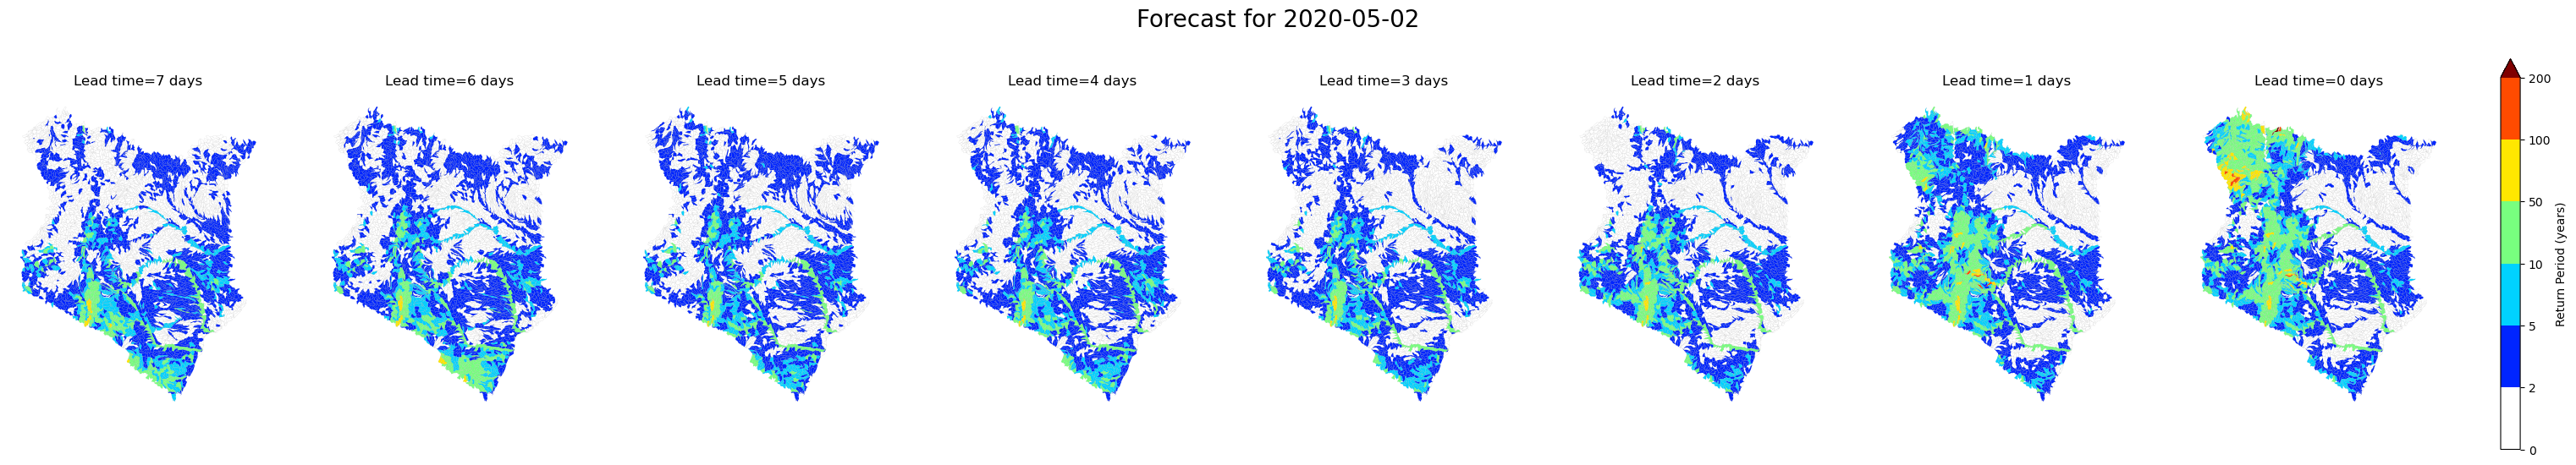

In [27]:
# Plot this
# Preprocess return periods < 2 to 0
lead_merge_df['plot_rp'] = lead_merge_df['estimated_rp'].apply(lambda x: x if x >= 2 else 0)

# Define boundaries & create colormap + norm (same as before)
bounds = [0, 2, 5, 10, 50, 100, 200]
base_cmap = plt.get_cmap('jet')
new_colors = ['#ffffff'] + [base_cmap(i) for i in range(base_cmap.N)]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_jet", new_colors, N=256)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N, extend='max')

# Create subplots for L=7 down to L=0
fig, axes = plt.subplots(1, 8, figsize=(40, 6))

for ax, L in zip(axes, range(7, -1, -1)):
    # The issue time for a forecast that targets date 'selected_date' at lead L
    issue_t = selected_date - pd.Timedelta(days=L)
    
    # Filter the dataframe by that issue_time and lead_time
    subset = lead_merge_df[
        (lead_merge_df['issue_time'] == issue_t) &
        (lead_merge_df['lead_time'] == f"{L} days")
    ]
    
    subset.plot(
        column='plot_rp', cmap=cmap, norm=norm,
        linewidth=0.05, edgecolor='grey',
        legend=False, ax=ax
    )
    
    ax.set_title(f"Lead time={L} days")
    ax.axis('off')


fig.suptitle(f"Forecast for {selected_date.strftime('%Y-%m-%d')}", fontsize=20)
# Common colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(),
                    orientation='vertical', fraction=0.05, pad=0.02,
                    ticks=bounds)
cbar.set_label("Return Period (years)")

plt.show()

#### Step 7: Plot for streamflow severity thresholds

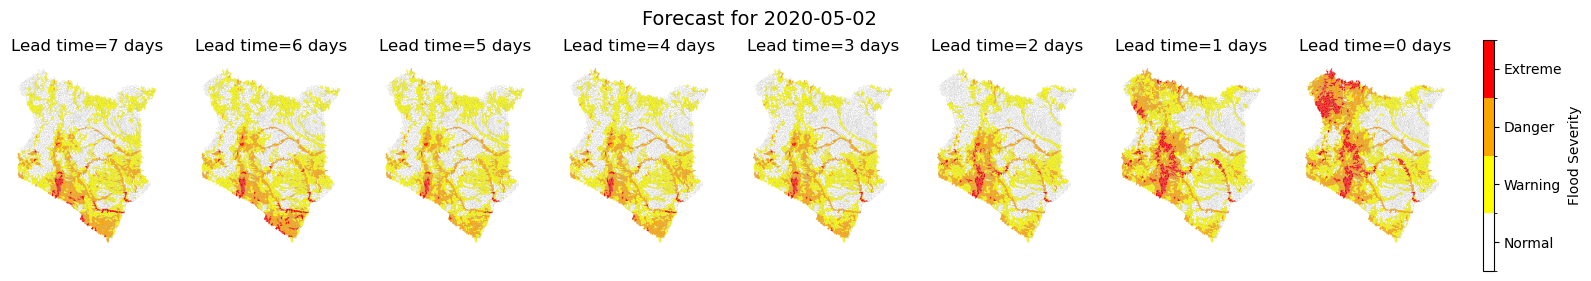

In [28]:
# --- Define the discrete colormap ---
# Colors for each category:
colors = ["white", "yellow", "orange", "red"]
cmap = mcolors.ListedColormap(colors)

# Create a normalization with boundaries that separate the 4 categories.
# Boundaries: [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=cmap.N)

# --- Create subplots (one per lead time) ---
fig, axes = plt.subplots(1, 8, figsize=(20, 3))

for ax, L in zip(axes, range(7, -1, -1)):
    # The issue time for a forecast that targets date 'selected_date' at lead L
    issue_t = selected_date - pd.Timedelta(days=L)
    
    # Filter the dataframe by that issue_time and lead_time
    subset = lead_merge_df[
        (lead_merge_df['issue_time'] == issue_t) &
        (lead_merge_df['lead_time'] == f"{L} days")
    ]
    
    subset.plot(
        column='severity_code', cmap=cmap, norm=norm,
        linewidth=0.05, edgecolor='grey',
        legend=False, ax=ax
    )
    
    ax.set_title(f"Lead time={L} days")
    ax.axis('off')

fig.suptitle(f"Forecast for {selected_date.strftime('%Y-%m-%d')}", fontsize=14)
# --- Create a common colorbar ---
# We use a dummy ScalarMappable with our discrete colormap and normalization.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # dummy array for the scalar mappable
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', 
                    fraction=0.05, pad=0.02, ticks=[0, 1, 2, 3])
# Set tick labels to the flood severity categories.
cbar.ax.set_yticklabels(["Normal", "Warning", "Danger", "Extreme"])
cbar.set_label("Flood Severity")

plt.show()